In [1]:
import hddm

passing through Knoderegress


/users/afengler/data/software/miniconda3/envs/hddm-gpu/lib/python3.7/site-packages/IPython/parallel.py:13: ShimWarning: The `IPython.parallel` package has been deprecated since IPython 4.0. You should import from ipyparallel instead.
  "You should import from ipyparallel instead.", ShimWarning)


In [2]:
import tensorflow as tf
import torch
# Make simulators visible
import sys
#sys.path.append('simulators')

# Data management
import pandas as pd
import numpy as np
import pickle

# Plotting
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns

# Stats functionality
from statsmodels.distributions.empirical_distribution import ECDF

In [4]:
# Metadata
nmcmc = 1000
model = 'ddm_seq2_no_bias'
n_samples = 1000
includes = hddm.simulators.model_config[model]['hddm_include'] # Note, this makes sure you include all parameters which is not necessary ! You could also instead include fewer parameters.

In [5]:
hddm.simulators.model_config[model]['hddm_include']

['vh', 'vl1', 'vl2', 'a', 't']

In [6]:
# Config for our current model
hddm.model_config.model_config[model]

{'params': ['vh', 'vl1', 'vl2', 'a', 't'],
 'param_bounds': [[-2.5, -2.5, -2.5, 0.3, 0.0], [2.5, 2.5, 2.5, 2.0, 2.0]],
 'params_trans': [0, 0, 0, 0, 0],
 'params_std_upper': [1.5, 1.5, 1.5, 1.0, 1.0],
 'boundary': <function hddm.simulators.boundary_functions.constant(t=0)>,
 'n_params': 5,
 'default_params': [0.0, 0.0, 0.0, 1.0, 1.0],
 'hddm_include': ['vh', 'vl1', 'vl2', 'a', 't'],
 'n_choices': 4,
 'choices': [0, 1, 2, 3],
 'slice_widths': {'vh': 1.5,
  'vh_std': 0.5,
  'vl1': 1.5,
  'vl1_std': 0.5,
  'vl2': 1.5,
  'vl2_std': 0.5,
  'a': 1,
  'a_std': 1,
  't': 0.01,
  't_std': 0.15}}

In [14]:
# test regressors only False
# add p_outliers to the generator !
data, full_parameter_dict = hddm.simulators.hddm_dataset_generators.simulator_h_c(n_subjects = 1,
                                                                                  n_trials_by_subject = n_samples,
                                                                                  model = model,
                                                                                  p_outlier = 0.00,
                                                                                  conditions = None, 
                                                                                  depends_on = None, 
                                                                                  regression_models = None,
                                                                                  regression_covariates = None,
                                                                                  group_only_regressors = False,
                                                                                  group_only = None,
                                                                                  fixed_at_default = None)

None
{'vl2', 't', 'a', 'vl1', 'vh'}
           vh      vl1       vl2         a         t
0    1.346941 -0.12953 -1.239659  1.810153  0.909745
1    1.346941 -0.12953 -1.239659  1.810153  0.909745
2    1.346941 -0.12953 -1.239659  1.810153  0.909745
3    1.346941 -0.12953 -1.239659  1.810153  0.909745
4    1.346941 -0.12953 -1.239659  1.810153  0.909745
..        ...      ...       ...       ...       ...
995  1.346941 -0.12953 -1.239659  1.810153  0.909745
996  1.346941 -0.12953 -1.239659  1.810153  0.909745
997  1.346941 -0.12953 -1.239659  1.810153  0.909745
998  1.346941 -0.12953 -1.239659  1.810153  0.909745
999  1.346941 -0.12953 -1.239659  1.810153  0.909745

[1000 rows x 5 columns]


In [15]:
help(hddm.simulators.hddm_dataset_generators.simulator_h_c)

Help on function simulator_h_c in module hddm.simulators.hddm_dataset_generators:

simulator_h_c(n_subjects=10, n_trials_by_subject=100, model='ddm_vanilla', conditions={'c_one': ['high', 'low'], 'c_two': ['high', 'low'], 'c_three': ['high', 'medium', 'low']}, depends_on={'v': ['c_one', 'c_two']}, regression_models=['z ~ covariate_name'], regression_covariates={'covariate_name': {'type': 'categorical', 'range': (0, 4)}}, group_only_regressors=True, group_only=['z'], fixed_at_default=['t'], p_outlier=0.0, outlier_max_t=10.0)
    Flexible simulator that allows specification of models very similar to the hddm model classes.
    
    :Arguments:
        n_subjects: int <default=5>
            Number of subjects in the datasets
        n_trials_by_subject: int <default=500>
            Number of trials for each subject
        model: str <default = 'ddm_vanilla'>
            Model to sample from. For traditional hddm supported models, append '_vanilla' to the model. Omitting 'vanilla'
     

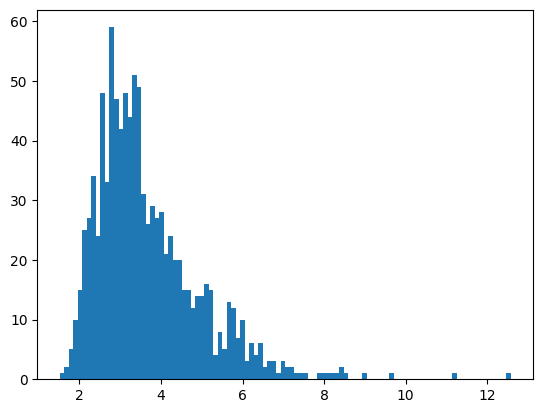

In [16]:
plt.hist(data['rt'], bins = 100)
plt.show()

In [17]:
data_single_s = hddm.simulators.simulator_single_subject(parameters = [-2.03, 0.74, -1.60, 1.9091, 0.07],
                                                         model = model)

Model:  ddm_seq2_no_bias
Parameters needed:  ['vh', 'vl1', 'vl2', 'a', 't']
[-2.03, 0.74, -1.6, 1.9091, 0.07]
theta is supplied as list --> simulator assumes n_trials = 1


In [18]:
data_single_s

(           rt  response subj_idx    vh   vl1  vl2       a     t
 0    5.172813         1     none -2.03  0.74 -1.6  1.9091  0.07
 1    3.894905         1     none -2.03  0.74 -1.6  1.9091  0.07
 2    3.360944         1     none -2.03  0.74 -1.6  1.9091  0.07
 3    3.925903         1     none -2.03  0.74 -1.6  1.9091  0.07
 4    2.441010         1     none -2.03  0.74 -1.6  1.9091  0.07
 ..        ...       ...      ...   ...   ...  ...     ...   ...
 995  3.556930         0     none -2.03  0.74 -1.6  1.9091  0.07
 996  1.948032         1     none -2.03  0.74 -1.6  1.9091  0.07
 997  2.402013         1     none -2.03  0.74 -1.6  1.9091  0.07
 998  4.188884         1     none -2.03  0.74 -1.6  1.9091  0.07
 999  2.212027         1     none -2.03  0.74 -1.6  1.9091  0.07
 
 [1000 rows x 8 columns],
 {'vh': -2.03, 'vl1': 0.74, 'vl2': -1.6, 'a': 1.9091, 't': 0.07})

In [19]:
hddmnn_torch_model.gen_stats()

NameError: name 'hddmnn_torch_model' is not defined

In [20]:
hddmnn_torch_model.data

NameError: name 'hddmnn_torch_model' is not defined

In [21]:
# Define the HDDM model
hddmnn_torch_model = hddm.HDDMnn(data_single_s[0],
                           informative = False,
                           include = includes,
                           p_outlier = 0.0,
                           w_outlier = 0.01,
                           model = model,
                           network_type = 'torch_mlp')


# Define the HDDM model
# hddmnn_keras_model = hddm.HDDMnn(data,
#                            informative = False,
#                            include = includes,
#                            p_outlier = 0.0,
#                            w_outlier = 0.01,
#                            model = model,
#                            network_type = 'mlp')


# # Define the HDDM model
# hddm_model = hddm.HDDM(data,
#                            informative = False,
#                            include = ['z'],
#                            p_outlier = 0.0)

Setting priors uninformative (LANs only work with uninformative priors for now)
tanh
tanh
tanh
linear
def custom_likelihood(x, vh, vl1, vl2, a, t, p_outlier=0.0, w_outlier=0.1, network = None):
    return hddm.wfpt.wiener_like_nn_mlp(x["rt"].values, x["response"].values, np.array([vh, vl1, vl2, a, t], dtype = np.float32), p_outlier=p_outlier, w_outlier=w_outlier, network=network)
{'model': 'ddm_seq2_no_bias', 'likelihood_str': 'def custom_likelihood(x, vh, vl1, vl2, a, t, p_outlier=0.0, w_outlier=0.1, network = None):\n    return hddm.wfpt.wiener_like_nn_mlp(x["rt"].values, x["response"].values, np.array([vh, vl1, vl2, a, t], dtype = np.float32), p_outlier=p_outlier, w_outlier=w_outlier, network=network)', 'custom_likelihood': <function custom_likelihood at 0x7f02381af3b0>}
<function custom_likelihood at 0x7f02381af3b0>
{}
['vh', 'vl1', 'vl2', 'a', 't']
printing self.nn
True
More than 2-choice model --> don't flip any responses.
Make sure you supplied rt and choice data in appropriate 

In [22]:
# Sample torch
hddmnn_torch_model.sample(nmcmc,
                          burn = 100)

 [-----------------100%-----------------] 1000 of 1000 complete in 15.5 sec

In [31]:
# Sample torch
hddmnn_keras_model.sample(nmcmc,
                          burn = 100)

 [-----------------100%-----------------] 1000 of 1000 complete in 31.1 sec

In [32]:
# Sample torch
hddm_model.sample(nmcmc,
                  burn = 100)

 [-----------------100%-----------------] 1000 of 1000 complete in 14.0 sec

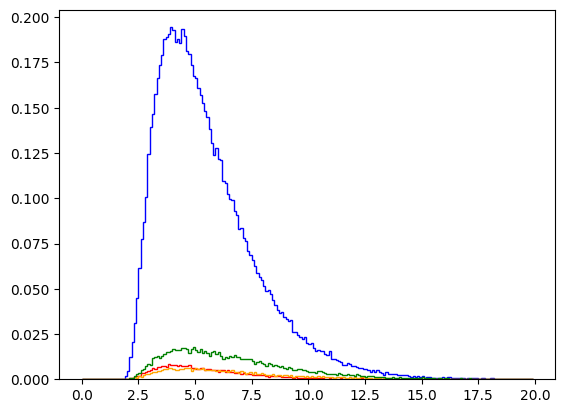

In [44]:
# Check if posteriors make sense
import ssms
#model = 'ddm_seq2_no_bias'
#d_s = [0, 0.25, 0.5, 1]
#0.965845	2.140491	-0.733678	1.797468	0.962645
n_samples = 200000
theta = [-0.54, -0.91, 0.29, 1.75, 1.31] #, 1.0]
out = ssms.basic_simulators.simulator(theta = theta,
                                      model = model,
                                      n_samples = n_samples)

#if d == 0:
color = ['blue', 'red', 'orange', 'green']
cnt = 0

for c in [0, 1, 2, 3]:
    choice_prop = out['rts'][out['choices'] == c].shape[0] / out['rts'].shape[0]
    weights = np.tile(( 1 / 0.1 ) / n_samples , reps = out['rts'][out['choices'] == c].shape[0])
    plt.hist(out['rts'][out['choices'] == c], range = (0, 20), bins = np.arange(0, 20, 0.1), weights = weights, histtype = 'step', color = color[c])
    
plt.show()
#else:
#plt.hist(out['rts'][out['choices'] == 3], range = (0, 1), bins = 100, histtype = 'step', alpha = d, color = 'black')

In [38]:
my_model = hddm.network_inspectors.load_torch_mlp(model = model)

tanh
tanh
tanh
linear


In [39]:
n_choices = 4
choice_options = [0, 1, 2, 3]

rts = np.expand_dims(np.concatenate([np.arange(0, 20, 0.01) for i in range(n_choices)]), axis = 1) #, np.arange(0,10, 0.01), np.arange(0,10, 0.01)]), axis = 1)
choices = np.concatenate([[c for i in range(2000)] for c in choice_options])
thetas = np.tile(np.array(theta), reps = (rts.shape[0],1))
my_data = np.column_stack([thetas, rts, choices]).astype(np.float32)

my_data = np.column_stack([my_data, np.exp(my_model.predict_on_batch(my_data))])

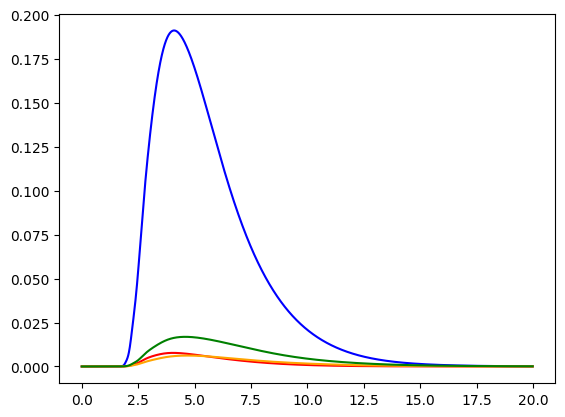

In [40]:
color = ['blue', 'red', 'orange', 'green']

for c in [0, 1, 2, 3]: #  2, 3]:
    plt.plot(my_data[my_data[:, -2] == c, -3], my_data[my_data[:, -2] == c, -1], color = color[c])
    
plt.show()

In [55]:
my_model.predict_on_batch(my_data)[200:400]

array([[-2.9842205],
       [-3.0018148],
       [-3.0193994],
       [-3.0369725],
       [-3.0545335],
       [-3.072081 ],
       [-3.0896122],
       [-3.1071305],
       [-3.124631 ],
       [-3.1421156],
       [-3.1595807],
       [-3.1770263],
       [-3.19445  ],
       [-3.2118537],
       [-3.2292352],
       [-3.2465918],
       [-3.2639241],
       [-3.28123  ],
       [-3.298509 ],
       [-3.3157601],
       [-3.3329828],
       [-3.3501744],
       [-3.3673358],
       [-3.3844662],
       [-3.4015641],
       [-3.4186282],
       [-3.4356601],
       [-3.4526558],
       [-3.4696178],
       [-3.4865456],
       [-3.503438 ],
       [-3.520295 ],
       [-3.5371184],
       [-3.553907 ],
       [-3.57066  ],
       [-3.5873792],
       [-3.6040664],
       [-3.62072  ],
       [-3.637342 ],
       [-3.653932 ],
       [-3.6704924],
       [-3.687024 ],
       [-3.703528 ],
       [-3.720004 ],
       [-3.736456 ],
       [-3.7528834],
       [-3.769288 ],
       [-3.78

In [57]:
# my_data[my_data[:, -2] == 1, -1]

In [58]:
# my_data[my_data[:, -2] == c, -3]

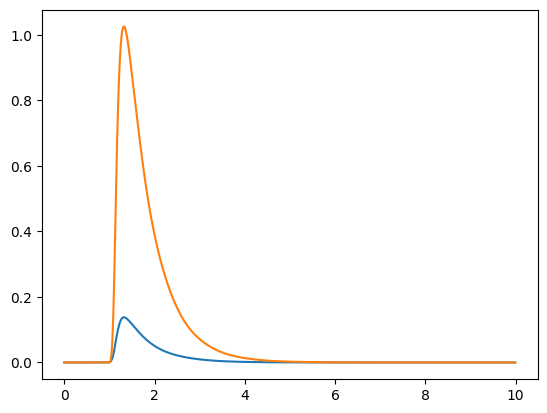

In [59]:
for c in [-1, 1]: #  2, 3]:
    plt.plot(my_data[my_data[:, -2] == c, -3], my_data[my_data[:, -2] == c, -1])
    
plt.show()

In [90]:
hddmnn_torch_model.gen_stats()

,mean,std,2.5q,25q,50q,75q,97.5q,mc err
v,-0.835013,0.063645,-0.972336,-0.870727,-0.828122,-0.789445,-0.725923,0.005049
a,1.953415,0.127402,1.703743,1.861096,1.962274,2.049738,2.184857,0.011269
z,0.218581,0.02364,0.2,0.200035,0.204935,0.23738,0.276275,0.002294
t,1.461071,0.017235,1.423085,1.45041,1.462389,1.473978,1.490604,0.001452
alpha,2.14477,0.373354,1.583839,1.866542,2.091147,2.374833,3.023263,0.021018
beta,5.901999,0.652729,4.636328,5.399552,5.928585,6.470178,6.946675,0.039786


In [34]:
hddmnn_keras_model.gen_stats()

,mean,std,2.5q,25q,50q,75q,97.5q,mc err
v,1.539898,0.084923,1.374631,1.487195,1.534603,1.597418,1.713643,0.00631
a,1.114885,0.058523,0.998365,1.072007,1.118218,1.156703,1.227973,0.004703
z,0.286156,0.021858,0.243743,0.271483,0.285931,0.301284,0.328868,0.001338
alpha,1.162843,0.116063,1.002862,1.039103,1.169018,1.261626,1.35958,0.00836
t,1.504488,0.007513,1.489581,1.499506,1.504313,1.509378,1.519018,0.000381


In [35]:
hddm_model.gen_stats()

,mean,std,2.5q,25q,50q,75q,97.5q,mc err
a,2.049559,0.035724,1.984713,2.025258,2.047264,2.073232,2.122854,0.001638
v,0.975918,0.046257,0.88843,0.943815,0.976287,1.007558,1.063487,0.002427
t,1.392762,0.008219,1.375611,1.387262,1.393266,1.398697,1.407272,0.000369
z,0.369303,0.010904,0.348281,0.362223,0.369599,0.376583,0.390254,0.000526


In [55]:
dir(hddmnn_torch_model)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_approximate_map_subj',
 '_create_an_average_model',
 '_create_family_exp',
 '_create_family_gamma_gamma_hnormal',
 '_create_family_invlogit',
 '_create_family_normal',
 '_create_family_normal_non_centered',
 '_create_family_normal_normal_hnormal',
 '_create_family_trunc_normal',
 '_create_stochastic_knodes',
 '_create_stochastic_knodes_info',
 '_create_stochastic_knodes_nn_noninfo',
 '_create_stochastic_knodes_noninfo',
 '_create_wfpt_knode',
 '_create_wfpt_parents_dict',
 '_kwargs',
 '_num_subjs',
 '_optimization_single',
 '_output_stats',
 '_partial_optimize',
 '_quant

In [81]:
dir(hddmnn_torch_model.mcmc().db)

['__Trace__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__name__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_finalize',
 '_initialize',
 '_traces',
 'chains',
 'close',
 'commit',
 'connect_model',
 'dbname',
 'getstate',
 'savestate',
 'tally',
 'trace',
 'trace_names',
 'truncate']

In [82]:
hddmnn_torch_model.mcmc().db.trace_names

[]

In [86]:
hddm_model.mcmc().db.trace_names

[]

In [87]:
hddm_model.get_traces()

,a,v,t,z_trans
0,3.981690,0.707008,1.552127,-0.229724
1,3.966550,0.687102,1.558296,-0.278494
2,4.010323,0.695428,1.504113,-0.281882
3,4.044400,0.698848,1.530022,-0.293732
4,4.025534,0.719221,1.515409,-0.331316
...,...,...,...,...
895,4.175195,0.752149,1.422557,-0.417910
896,4.151741,0.766553,1.441120,-0.360975
897,4.210276,0.764354,1.441521,-0.348054
898,4.120845,0.746528,1.509580,-0.282352


In [100]:
hddm_model.mc.db._traces

{}

In [101]:
hddm_model.get_stochastics()

,knode_name,stochastic,observed,subj,node,tag,depends,hidden,rt,response,...,z,t,mean,std,2.5q,25q,50q,75q,97.5q,mc err
a,a,True,False,False,a,(),[],False,NaN,NaN,...,NaN,NaN,4.122176,0.086789,3.959831,4.066472,4.116039,4.178776,4.303092,0.005541
v,v,True,False,False,v,(),[],False,NaN,NaN,...,NaN,NaN,0.726471,0.028049,0.670944,0.70685,0.726347,0.745147,0.78047,0.001583
t,t,True,False,False,t,(),[],False,NaN,NaN,...,NaN,NaN,1.469925,0.041688,1.380997,1.44598,1.473405,1.498159,1.543966,0.0028
z_trans,z_trans,True,False,False,z_trans,(),[],True,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [103]:
hddm_model.get_deterministic()

AttributeError: 'HDDM' object has no attribute 'get_deterministic'

In [107]:
hddm_model.nodes_db

,knode_name,stochastic,observed,subj,node,tag,depends,hidden,rt,response,...,z,t,mean,std,2.5q,25q,50q,75q,97.5q,mc err
a,a,True,False,False,a,(),[],False,NaN,NaN,...,NaN,NaN,4.122176,0.086789,3.959831,4.066472,4.116039,4.178776,4.303092,0.005541
v,v,True,False,False,v,(),[],False,NaN,NaN,...,NaN,NaN,0.726471,0.028049,0.670944,0.70685,0.726347,0.745147,0.78047,0.001583
t,t,True,False,False,t,(),[],False,NaN,NaN,...,NaN,NaN,1.469925,0.041688,1.380997,1.44598,1.473405,1.498159,1.543966,0.0028
z_trans,z_trans,True,False,False,z_trans,(),[],True,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
z,z,False,False,False,z,(),[],False,NaN,NaN,...,NaN,NaN,0.419083,0.013539,0.392202,0.409575,0.419275,0.428044,0.44562,0.00079
wfpt,wfpt,False,True,False,wfpt,(),[],False,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [133]:
tmp = hddm_model.nodes_db[(hddm_model.nodes_db.stochastic == True) | ((hddm_model.nodes_db.stochastic == False) & (hddm_model.nodes_db.observed == False))] # hddm_model.nodes_db.observed == False]
#tmp = tmp[tmp.observed == False, ]

In [150]:
for idx in tmp.index:
    print(idx)
    print(tmp.loc[idx].node.trace())
    #print(tmp[idx, :].node)

a
[3.98169021 3.96655014 4.0103234  4.0443996  4.02553372 4.20615519
 4.20799522 4.27602711 4.05944572 4.09083529 4.15850348 4.24022004
 4.37821522 4.31625564 4.30358808 4.39928537 4.24026939 4.32644424
 4.26290777 4.36117385 4.15317485 4.09653808 4.01510439 3.95706678
 4.07426519 4.08115854 4.16978896 4.22319548 4.16246874 4.10635118
 4.03978538 4.19035219 4.12815013 4.13959789 4.1130292  4.06727276
 4.10156489 4.1148719  4.07776562 4.10012619 4.17934604 4.03319202
 4.01171902 4.1716917  4.20872426 4.12819977 4.1285183  4.01436927
 3.97476322 4.12231352 4.12040578 4.13519032 4.13730257 4.03080863
 4.08951122 4.11937272 4.20955866 4.18793679 4.11087322 4.09627027
 4.06754745 4.05960332 4.18505823 4.15629928 4.21165445 4.18999043
 4.15210362 4.08771046 4.07282351 4.05822566 4.12235091 4.17523446
 4.18189757 4.18416237 4.17877646 4.04208591 4.21242929 4.11587211
 4.1439344  4.17295062 4.09427375 4.11016041 4.09618955 4.13573604
 4.1071792  4.08403836 4.09064926 4.20510071 4.03064387 4.07

In [145]:
tmp.index

Index(['a', 'v', 't', 'z_trans', 'z'], dtype='object')

In [127]:
tmp.loc['z', :].node.trace()

array([0.44282035, 0.43082297, 0.42999242, 0.42709049, 0.41792048,
       0.42256716, 0.4182892 , 0.41898075, 0.42047371, 0.40500877,
       0.4134671 , 0.40693889, 0.37949011, 0.37895345, 0.39552337,
       0.38754605, 0.40964192, 0.42360087, 0.42798751, 0.42355866,
       0.42541122, 0.42266353, 0.43738353, 0.43508919, 0.41811747,
       0.40963267, 0.41614237, 0.39836867, 0.40427717, 0.41181476,
       0.41257876, 0.4104638 , 0.43476855, 0.44558916, 0.4323991 ,
       0.43798861, 0.43375284, 0.42377155, 0.410446  , 0.42008577,
       0.41899661, 0.41517313, 0.42323658, 0.43893135, 0.44054828,
       0.44561996, 0.44157254, 0.42685977, 0.4086088 , 0.41733168,
       0.41712416, 0.43069211, 0.40948367, 0.40851257, 0.42465862,
       0.42361234, 0.41231257, 0.40596166, 0.40960605, 0.41263802,
       0.40539327, 0.42323285, 0.42977926, 0.43955877, 0.43142307,
       0.43059441, 0.42431218, 0.422591  , 0.42812361, 0.42668915,
       0.42067417, 0.41130513, 0.43863816, 0.42860179, 0.42155